NLP Final Project

Wilson Neira

In [87]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

# Dataset path
dataset_path = "archive"  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load emails from folders
def load_emails():
    emails = []
    labels = []
    
    for i in range(1, 7):
        enron_folder = os.path.join(dataset_path, f'enron{i}')
        
        # Spam folder
        spam_folder = os.path.join(enron_folder, 'spam')
        for filename in os.listdir(spam_folder):
            with open(os.path.join(spam_folder, filename), 'r', encoding='latin-1') as f:
                emails.append(f.read())
                labels.append('spam')
        
        # Ham folder
        ham_folder = os.path.join(enron_folder, 'ham')
        for filename in os.listdir(ham_folder):
            with open(os.path.join(ham_folder, filename), 'r', encoding='latin-1') as f:
                emails.append(f.read())
                labels.append('ham')
    
    return emails, labels

# Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Load and preprocess emails
emails, labels = load_emails()
preprocessed_emails = [preprocess_text(email) for email in emails]

# Convert to DataFrame
df = pd.DataFrame({'email': preprocessed_emails, 'label': labels})

# Split data 
train_emails, test_emails, train_labels, test_labels = train_test_split(
    df['email'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [89]:

print(sum(label == 'spam'for label in train_labels))
print(sum(label == 'ham'for label in train_labels))

13736
13236


In [90]:
# Vectorization (train only)
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_emails)
X_test = vectorizer.transform(test_emails)

# Dimensionality Reduction (train only)
svd = TruncatedSVD(n_components=100)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

Exploratory Data Analysis

In [91]:
# K-Means Clustering (train only)
kmeans = KMeans(n_clusters=6, random_state=42)
train_clusters = kmeans.fit_predict(X_train_reduced)
test_clusters = kmeans.predict(X_test_reduced)

# Hierarchical Clustering (train only)
hierarchical = AgglomerativeClustering(n_clusters=6)
train_hier_clusters = hierarchical.fit_predict(X_train_reduced)

# Assign hierarchical clusters to test using Nearest Centroid
centroid_clf = NearestCentroid().fit(X_train_reduced, train_hier_clusters)
test_hier_clusters = centroid_clf.predict(X_test_reduced)

In [97]:
# t-SNE Visualization (TRAIN Data Only)
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_reduced)

# Create train DataFrame for visualization
df_train_vis = pd.DataFrame({
    'tsne_x': X_train_tsne[:, 0],
    'tsne_y': X_train_tsne[:, 1],
    'label': train_labels,
    'kmeans_cluster': train_clusters,
    'hierarchical_cluster': train_hier_clusters
})

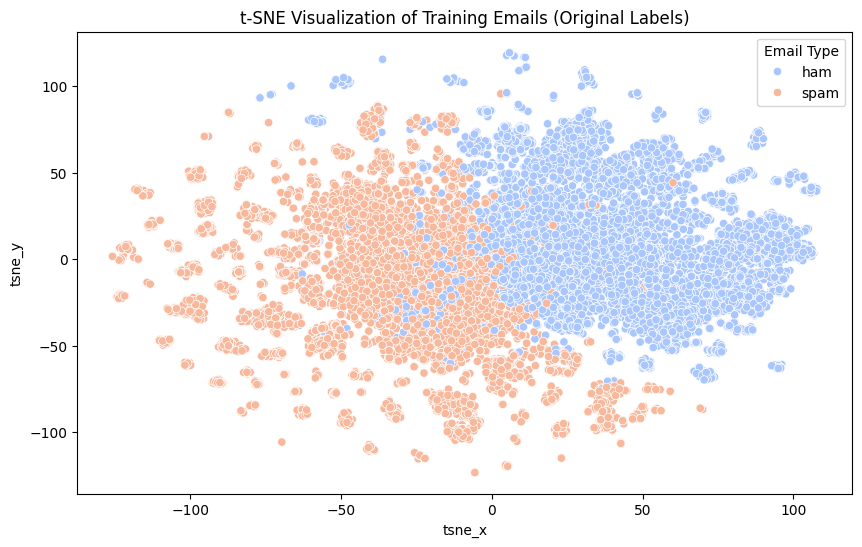

In [98]:
# Plot Original Labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='label', palette='coolwarm', data=df_train_vis)
plt.title('t-SNE Visualization of Training Emails (Original Labels)')
plt.legend(title="Email Type")
plt.show()

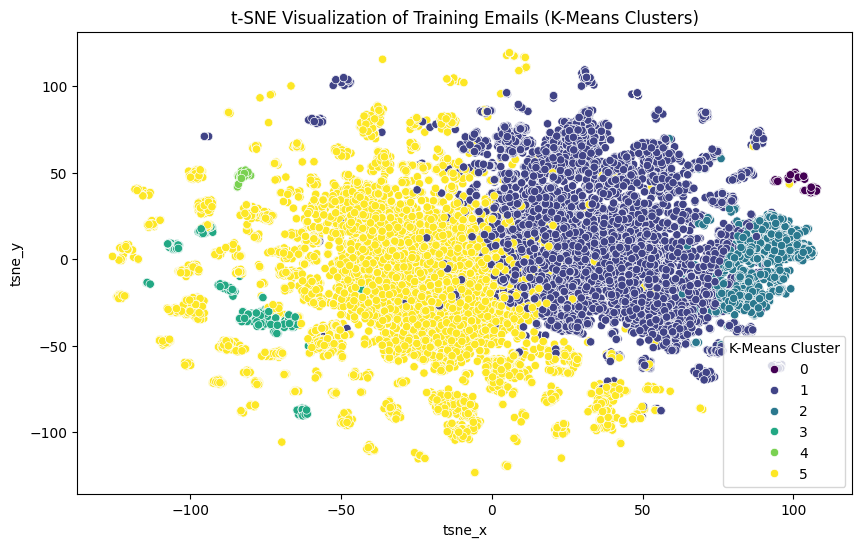

In [99]:
# Plot K-Means Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='kmeans_cluster', palette='viridis', data=df_train_vis)
plt.title('t-SNE Visualization of Training Emails (K-Means Clusters)')
plt.legend(title="K-Means Cluster")
plt.show()

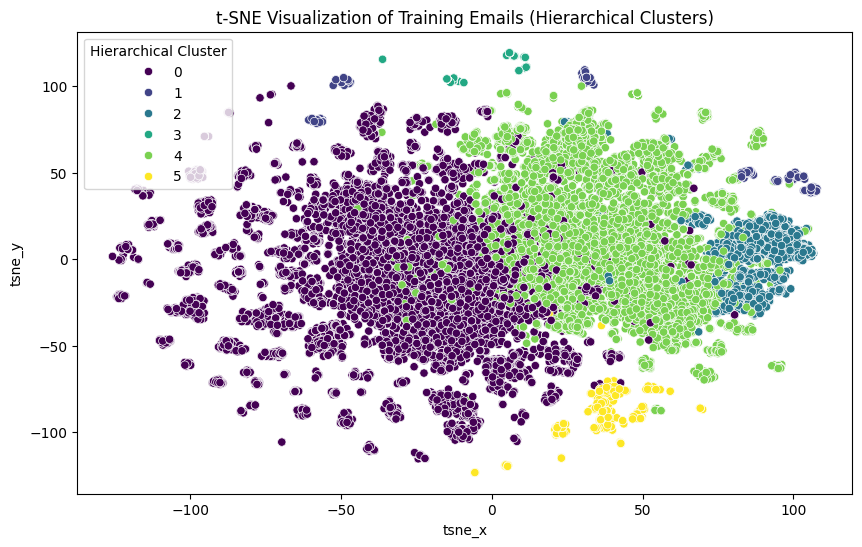

In [101]:
# Plot Hierarchical Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='hierarchical_cluster', palette='viridis', data=df_train_vis)
plt.title('t-SNE Visualization of Training Emails (Hierarchical Clusters)')
plt.legend(title="Hierarchical Cluster")
plt.show()

In [ ]:
# Save DataFrames with cluster labels
df_train = pd.DataFrame({
    'email': train_emails,
    'label': train_labels,
    'kmeans_cluster': train_clusters,
    'hierarchical_cluster': train_hier_clusters
})
df_test = pd.DataFrame({
    'email': test_emails,
    'label': test_labels,
    'kmeans_cluster': test_clusters,
    'hierarchical_cluster': test_hier_clusters
})

# Save processed datasets
df_train.to_csv("train_data_with_clusters.csv", index=False)
df_test.to_csv("test_data_with_clusters.csv", index=False)

print("Data clustering and training visualization complete. Train/test datasets with clusters saved.")